In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
data_path = os.getcwd() + "/"
test = os.path.join("mnist_train.csv")
print(test)
#train_data = np.loadtxt(data_path + "mnist_train.csv", 
#                        delimiter=",")
train_data = np.loadtxt(data_path+"mnist_train.csv",delimiter=",")
test_data = np.loadtxt(data_path+"mnist_test.csv",delimiter=",")
test_data[:10]

mnist_train.csv


array([[7., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [9., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.]])

Populating the interactive namespace from numpy and matplotlib
up here :  (60000, 784)
(60000, 28, 28)


(60000, 28, 28)

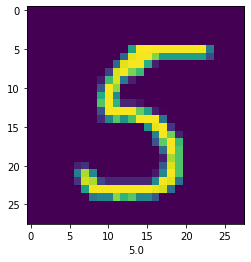

In [53]:
%pylab inline
import random
ran = random.randint(0,len(train_data))
fac = 0.99 / 255
print("up here : ",train_data[:,1:].shape)
train_imgs = np.asfarray(train_data[:, 1:],dtype="float32") * fac + 0.01
test_imgs = np.asfarray(test_data[:, 1:],dtype="float32") * fac + 0.01

train_imgs = train_imgs.reshape(train_imgs.shape[0],28,28)
test_imgs = test_imgs.reshape(test_imgs.shape[0],28,28)
print(train_imgs.shape)
train_labels = np.asfarray(train_data[:, :1],dtype="float32")
test_labels = np.asfarray(test_data[:, :1],dtype="float32")

test = train_imgs[ran].reshape((28,28))
train_labels = train_labels.reshape(train_labels.shape[0])
test_labels.reshape(test_labels.shape[0])
imshow(test)
xlabel(train_labels[ran])
train_imgs.reshape(train_imgs.shape[0],28,28).shape

In [62]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import trange
np.warnings.filterwarnings('ignore')

class the_net(torch.nn.Module):
    def __init__(self):
        super(the_net,self).__init__()
        self.l1 = nn.Linear(784,128,bias=False)
        #self.l2 = nn.Linear(128,10,bias=True)
        #self.l3 = nn.Linear(32,10,bias=False)
        #self.l2 = nn.BatchNorm1d(128)
        self.l2 = nn.Linear(128,10,bias=False)
        #self.l3 = nn.Linear(64,10,bias=False)
        #self.l4 = nn.Bilinear(64,10,10,bias=False)
        
        ############### softmin suuuuuuucks ##################
        self.soft_max = nn.Softmax(dim=1)
    def forward(self,x):
        x = F.relu(self.l1(x))
        
        #x = F.relu(self.l2(x))
        x = self.l2(x)
        #x = self.l3(x)
       # x = self.l3(x)
        x = self.soft_max(x)
        return x
        

loss -0.96 accuracy 0.95: 100%|██████████| 4000/4000 [00:19<00:00, 209.78it/s]


the_net(
  (l1): Linear(in_features=784, out_features=128, bias=False)
  (l2): Linear(in_features=128, out_features=10, bias=False)
  (soft_max): Softmax(dim=1)
)

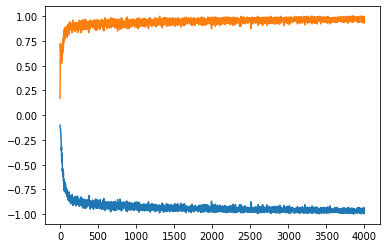

In [63]:
model = the_net()

# negative log likelyhood loss as log function
loss_function = nn.NLLLoss(reduction="none")
#loss_function = nn.CrossEntropyLoss(reduction="mean")
#qconfig = torch.quantization.get_default_qat_qconfig('qnnpack')
#torch.backends.quantized.engine = 'qnnpack'
optim = torch.optim.Adam(model.parameters(),lr=0.001)
iters = 4000
bs = 128
losses, accuracies = [], []

for i in (t := trange(iters)):
    samp = np.random.randint(0,train_imgs.shape[0],size=(bs))
    X = torch.tensor(train_imgs[samp].reshape((-1,28*28))).float()
    Y = torch.tensor(train_labels[samp]).long()
    model.zero_grad()
    out = model(X)
    cat = torch.argmax(out,dim=1)
    accuracy = (cat ==Y).float().mean()
    loss = loss_function(out,Y)
    loss = loss.mean()
    loss.backward()
    optim.step()
    loss,accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f"%(loss,accuracy))
plot(losses)
plot(accuracies)
model.eval()


6051
the predicted value:  2
True


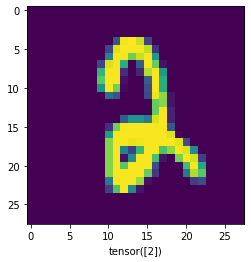

In [64]:
l1 = model.l1.weight.detach().numpy().T
l2 = model.l2.weight.detach().numpy().T
#l3 = model.l3.weight.detach().numpy().T
# numpy forward pass
def logsoftmax(x):
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())

def softmax(x):
    e_x = np.exp((x) - np.max(x))
    return e_x/e_x.sum()

def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(x):
    return np.maximum(x,0)


def forward(x):
    x = x.dot(l1)
    #print("the first x :",x)
    #x = x *l2  
    #print(x.shape)
    x = x.dot(l2)
    #x = sigmoid(x)
    #x = relu(x)
    x = logsoftmax(x)
    #x = x.dot(l3)
    #print("the second x: ",x)
    #x = x.dot(l3)
    return x

#test_img = torch.tensor(test_imgs[1].reshape((-1,28*28))).float()

the_ind = random.randint(0,test_imgs.shape[0])
print(the_ind)
test_label = torch.tensor(test_labels[the_ind]).long()

xlabel(test_label)
imshow(test_imgs[the_ind])

the_img = test_imgs[the_ind].reshape((28*28))
out = forward(the_img)

print("the predicted value: ",out.argmax())
print(int(out.argmax())==int(test_label))

In [65]:
def eval():
    acc = []
    right = 0
    for i in (t := trange(1,test_imgs.shape[0])):
        t.set_description("current acc "+str(round(right/i,3)))
        out = forward(test_imgs[i].reshape((28*28)))
        res = int(out.argmax())
        the_lab = int(test_labels[i])
        if res == the_lab:
            right += 1
            acc.append(True)
        else:
            acc.append(False)
    return acc, right/ test_imgs.shape[0]
acc,right = eval()
"test acc: ", right

current acc 0.84: 100%|██████████| 9999/9999 [00:15<00:00, 661.83it/s] 


('test acc: ', 0.8397)